In [1]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#@title Load Package

import gc
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.utils import plot_model

seed = 1
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from openslide import open_slide, __library_version__ as openslide_version
from PIL import Image
from skimage.color import rgb2gray

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#@title Load custom functions

import sys
sys.path.insert(0, '/content/drive/MyDrive/Colab Notebooks/ADL/project')

from config import RAW_DATA_DIR, PROCESSED_DATA_DIR, POS_DATA_DIR, NEG_DATA_DIR, MODEL_DIR, RES_DIR
from processing import (read_full_image, allocate_ones, allocate_zeros, get_patches_from_center, 
                        get_target, delete_gray, list_map_data_aug)
from create_model import create_three_zooms_model
from plot_heatmap import label_prediction, label_heatmap_multizooms

train_file = ["101", "094", "110", "016", "078", "031", "064"]
test_file = ["091", "075", "094", "084"]

In [4]:
#@title Build model

model = create_three_zooms_model()

model.compile(loss=losses.BinaryCrossentropy(from_logits=False),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.5))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 input2 (InputLayer)            [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 input3 (InputLayer)            [(None, 299, 299, 3  0           []                               
                                )]                                                            

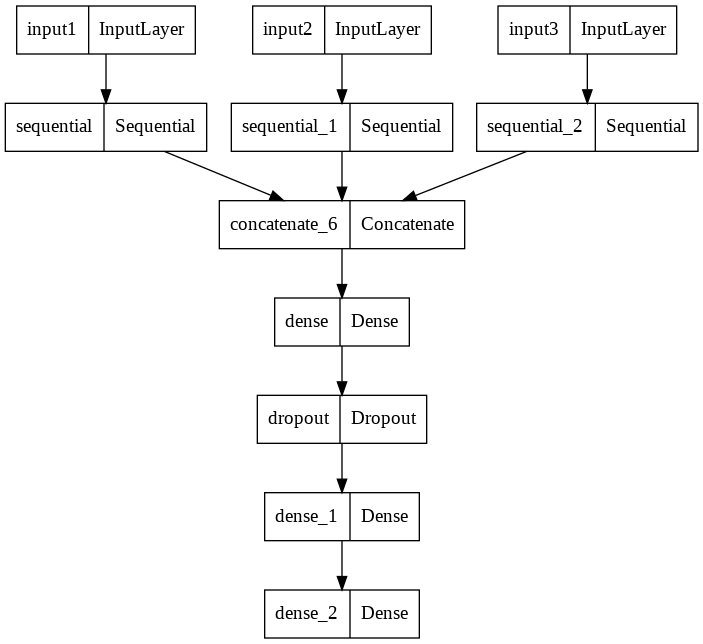

In [ ]:
base_model_structure = os.path.join(MODEL_DIR, 'model_threezooms_357.png')
plot_model(model, to_file=base_model_structure)

In [ ]:
#@title Training

sampling_times = 10
nsamples = 200
level_lst = [5, 6, 7]
val_split = 0.3

train_loss_lst = []
train_accuracy_lst = []
val_loss_lst = []
val_accuracy_lst = []


for s_i in range(sampling_times):

  for slide_num in train_file:
    print("\nStart Processing for", slide_num)
    multi_slide_images = []
    multi_mask_images = []
    for level in level_lst:
      slide_image = read_full_image(slide_num, level=level, ifmask=False)
      mask_image = read_full_image(slide_num, level=level, ifmask=True)
      multi_slide_images.append(slide_image)
      multi_mask_images.append(mask_image)

    all_ones = allocate_ones(multi_mask_images[-1])
    all_zeros = allocate_zeros(multi_slide_images[-1], multi_mask_images[-1])

    # Generate samples and train model
    neg_i = 0
    factor = 2 ** level_lst[-1]

    print("Sampling", s_i)
    start_ind = s_i * nsamples
    end_ind = (s_i+1) * nsamples

    if end_ind <= len(all_ones):

      # positive samples
      print("Generating positive samples......")
      pos_file = os.path.join(POS_DATA_DIR, f"{slide_num}_357_{s_i}.npy")

      if not os.path.exists(pos_file):
        print("------Process samples-------")
        selected_centers = all_ones[start_ind: end_ind]

        pos_pitch_lst = [[] for _ in range(len(level_lst))]
        for x_cen, y_cen in selected_centers:
          multi_check_images = get_patches_from_center(multi_mask_images, x_cen*factor, y_cen*factor, level_lst=level_lst)
          multi_tumor_regions = get_patches_from_center(multi_slide_images, x_cen*factor, y_cen*factor, level_lst=level_lst)
          assert multi_check_images[0].sum() != 0
          assert get_target(multi_check_images[0]) == 1.0

          for i in range(len(level_lst)):
            pos_pitch_lst[i].append(multi_tumor_regions[i] / 255.0)

        pos_pitch_lst = np.array(pos_pitch_lst)
        np.save(pos_file, pos_pitch_lst)

      else:
        print("------Load samples-------")
        pos_pitch_lst = np.load(pos_file)
      
      pos_pitch_lst = np.array(list(
            map(lambda x: list_map_data_aug(x), pos_pitch_lst)
            ))
      
      train_dataset = tf.data.Dataset.from_tensor_slices(
          ({'input1': np.array(pos_pitch_lst[0][int(val_split*nsamples) :]), 
            'input2': np.array(pos_pitch_lst[1][int(val_split*nsamples) :]),
            'input3': np.array(pos_pitch_lst[2][int(val_split*nsamples) :])}, 
          np.array([1.0] * nsamples)[int(val_split*nsamples) :])
          )

      val_dataset = tf.data.Dataset.from_tensor_slices(
          ({'input1': np.array(pos_pitch_lst[0][: int(val_split*nsamples)]), 
            'input2': np.array(pos_pitch_lst[1][: int(val_split*nsamples)]),
            'input3': np.array(pos_pitch_lst[2][: int(val_split*nsamples)])}, 
          np.array([1.0] * nsamples)[: int(val_split*nsamples)])
          )
      del pos_pitch_lst
      gc.collect()
      
      
      # negative samples
      print("Generating negative samples......")
      neg_file = os.path.join(NEG_DATA_DIR, f"{slide_num}_357_{s_i}.npy")

      if not os.path.exists(neg_file):
        print("------Process samples-------")
        neg_pitch_lst = [[] for _ in range(len(level_lst))]

        while len(neg_pitch_lst[0]) < nsamples:
          x_cen, y_cen = all_zeros[neg_i]

          multi_tumor_regions = get_patches_from_center(multi_slide_images, x_cen*factor, y_cen*factor, level_lst=level_lst)

          # Make sure that minimum zoom level have enough tissue
          if delete_gray(multi_tumor_regions[0]):
            multi_check_images = get_patches_from_center(multi_mask_images, x_cen*factor, y_cen*factor, level_lst=level_lst)

            # Make sure that minimum zoom level have tumor
            label = get_target(multi_check_images[0])
            if label == 0.0:
              for i in range(len(level_lst)):
                neg_pitch_lst[i].append(multi_tumor_regions[i] / 255.0)
          neg_i += 1
    
        neg_pitch_lst = np.array(neg_pitch_lst)
        np.save(neg_file, neg_pitch_lst)

      else:
        print("------Load samples-------")
        neg_pitch_lst = np.load(neg_file)
      
      neg_pitch_lst = np.array(list(
            map(lambda x: list_map_data_aug(x), neg_pitch_lst)
            ))

      train_dataset = train_dataset.concatenate(
          tf.data.Dataset.from_tensor_slices(
              ({'input1': np.array(neg_pitch_lst[0][int(val_split*nsamples) :]), 
                'input2': np.array(neg_pitch_lst[1][int(val_split*nsamples) :]),
                'input3': np.array(neg_pitch_lst[2][int(val_split*nsamples) :])}, 
              np.array([0.0] * nsamples)[int(val_split*nsamples) :])
              )
            )
      
      val_dataset = val_dataset.concatenate(
          tf.data.Dataset.from_tensor_slices(
              ({'input1': np.array(neg_pitch_lst[0][: int(val_split*nsamples)]), 
                'input2': np.array(neg_pitch_lst[1][: int(val_split*nsamples)]),
                'input3': np.array(neg_pitch_lst[2][: int(val_split*nsamples)])}, 
            np.array([0.0] * nsamples)[: int(val_split*nsamples)])
              )
          )
      del neg_pitch_lst
      gc.collect()   

      # Prepare dataset
      print("Prepare dataset......")
      BATCH_SIZE = 64
      SHUFFLE_BUFFER_SIZE = int(nsamples*2*(1-val_split))
      train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
      
      BATCH_SIZE = 64
      SHUFFLE_BUFFER_SIZE = int(nsamples*2*val_split)
      val_dataset = val_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

      print("Train model......")
      checkpoint_path = os.path.join(MODEL_DIR, "model_357_200.ckpt")
      cp_callback = tf.keras.callbacks.ModelCheckpoint(
          filepath=checkpoint_path, save_weights_only=True, verbose=1)
      
      history = model.fit(train_dataset, validation_data=val_dataset, epochs=2, callbacks=[cp_callback])

      del train_dataset, val_dataset
      gc.collect() 

      train_loss_lst.extend(history.history["loss"])
      train_accuracy_lst.extend(history.history["binary_accuracy"])
      val_loss_lst.extend(history.history["val_loss"])
      val_accuracy_lst.extend(history.history["val_binary_accuracy"])

      res_df = pd.DataFrame({
          "train_loss_lst": train_loss_lst,
          "train_accuracy_lst": train_accuracy_lst,
          "val_loss_lst": val_loss_lst,
          "val_accuracy_lst": val_accuracy_lst
      })
      res_file = os.path.join(RES_DIR, "res_357_200.csv")
      res_df.to_csv(res_file, index=False)




Start Processing for 101
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_101.tif with width: 17408, height: 8960
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_101_mask.tif with width: 17408, height: 8960
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_101.tif with width: 4352, height: 2240
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_101_mask.tif with width: 4352, height: 2240
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_101.tif with width: 1088, height: 560
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_101_mask.tif with width: 1088, height: 560
The number of tumor pixels 11756
The number of tumor pixels after filter 6350
The number of tissue 150818
The number of tumor 11756
The number of normal tissue 139078
The number of normal tissue af

In [ ]:
fig = px.line(
    res_df, 
    x=range(len(res_df)), 
    y=["train_loss_lst", "val_loss_lst"], 
    markers=True)
fig.show()

In [ ]:
fig = px.line(
    res_df, 
    x=range(len(res_df)), 
    y=["train_accuracy_lst", "val_accuracy_lst"], 
    markers=True)
fig.show()

In [ ]:
#@title Load Model

checkpoint_path = os.path.join(MODEL_DIR, "model_357_200.ckpt")
# Loads the weights
model.load_weights(checkpoint_path)


Label heatmap for 091
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_091.tif with width: 7680, height: 6720
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_091_mask.tif with width: 7680, height: 6720
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_091.tif with width: 1920, height: 1680
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_091_mask.tif with width: 1920, height: 1680
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_091.tif with width: 480, height: 420
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_091_mask.tif with width: 480, height: 420
The shape of predict_mask (6720, 7680)
The number of tumor of predict_mask 0.0
1.0 [[0.8382089]]
1.0 [[0.41984528]]
1.0 [[0.28725195]]
1.0 [[0.5150422]]
1.0 [[0.9972451]]
1.0 [[0.9945904]]
1.0 [[0.8335956

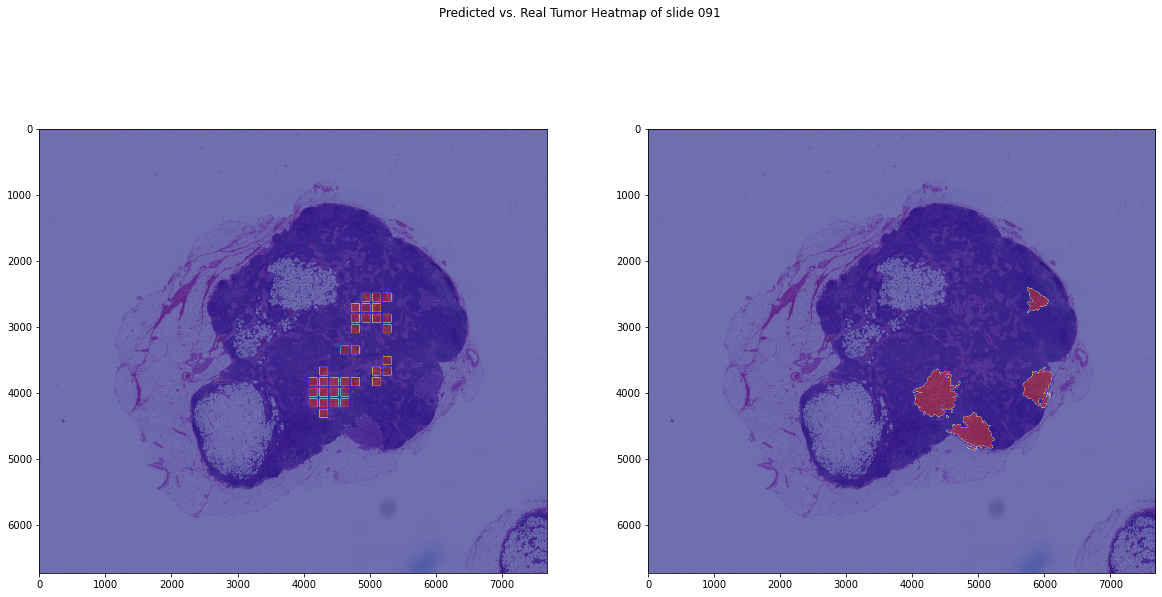


Label heatmap for 075
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_075.tif with width: 11264, height: 9856
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_075_mask.tif with width: 11264, height: 9856
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_075.tif with width: 2816, height: 2464
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_075_mask.tif with width: 2816, height: 2464
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_075.tif with width: 704, height: 616
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_075_mask.tif with width: 704, height: 616
The shape of predict_mask (9856, 11264)
The number of tumor of predict_mask 0.0
1.0 [[0.03490002]]
1.0 [[0.06327116]]
1.0 [[0.06772996]]
1.0 [[0.06005721]]
1.0 [[0.28715914]]
1.0 [[0.18072827]]
1.0 [[0.

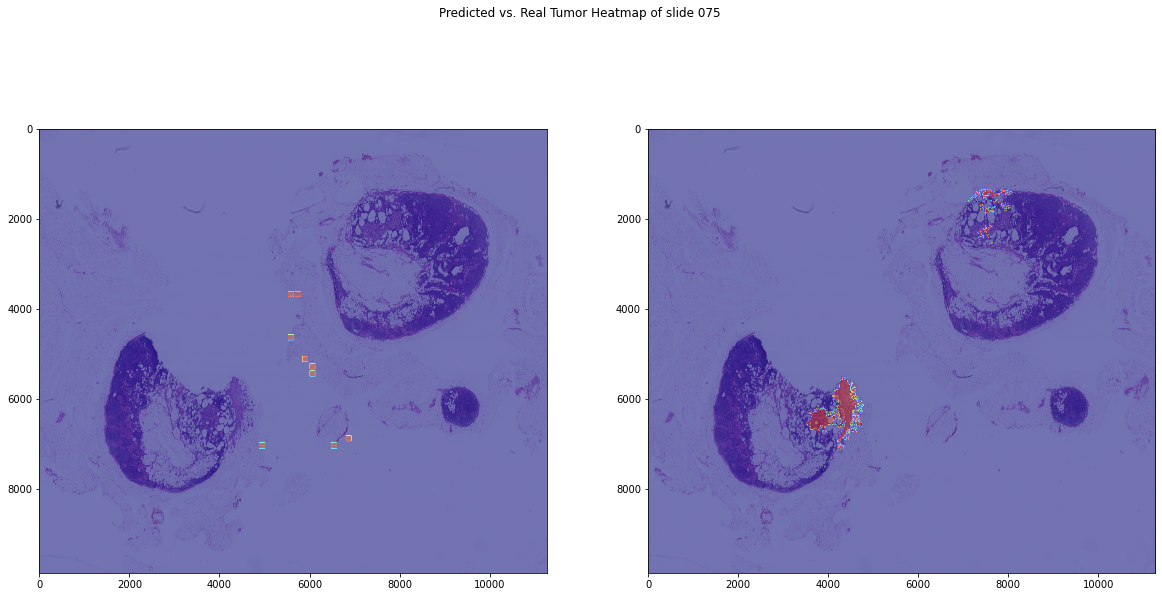


Label heatmap for 094
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_094.tif with width: 14848, height: 12544
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_094_mask.tif with width: 14848, height: 12544
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_094.tif with width: 3712, height: 3136
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_094_mask.tif with width: 3712, height: 3136
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_094.tif with width: 928, height: 784
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_094_mask.tif with width: 928, height: 784
The shape of predict_mask (12544, 14848)
The number of tumor of predict_mask 0.0
1.0 [[0.9251442]]
1.0 [[0.9761604]]
1.0 [[0.96080655]]
1.0 [[0.7976472]]
1.0 [[0.73511297]]
1.0 [[0.9824792]]
1.0 [[0.9

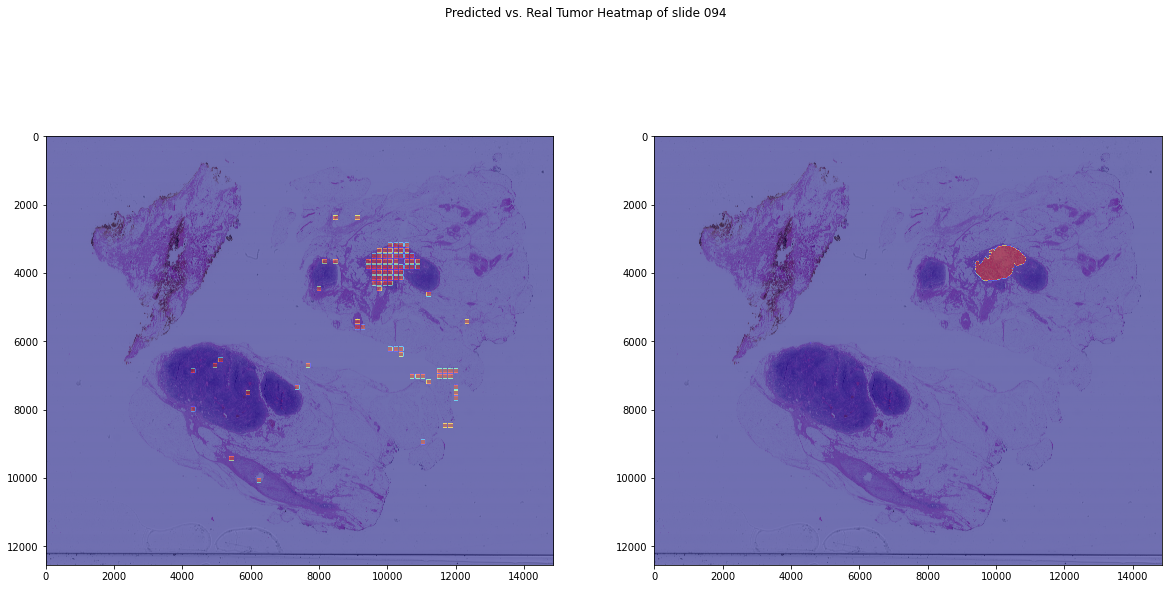


Label heatmap for 084
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_084.tif with width: 8192, height: 10752
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_084_mask.tif with width: 8192, height: 10752
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_084.tif with width: 2048, height: 2688
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_084_mask.tif with width: 2048, height: 2688
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_084.tif with width: 512, height: 672
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_084_mask.tif with width: 512, height: 672
The shape of predict_mask (10752, 8192)
The number of tumor of predict_mask 0.0
1.0 [[0.08242399]]
1.0 [[0.09821491]]
1.0 [[0.9098667]]
1.0 [[0.4810209]]
1.0 [[0.58278763]]
1.0 [[0.21777135]]
1.0 [[0.42

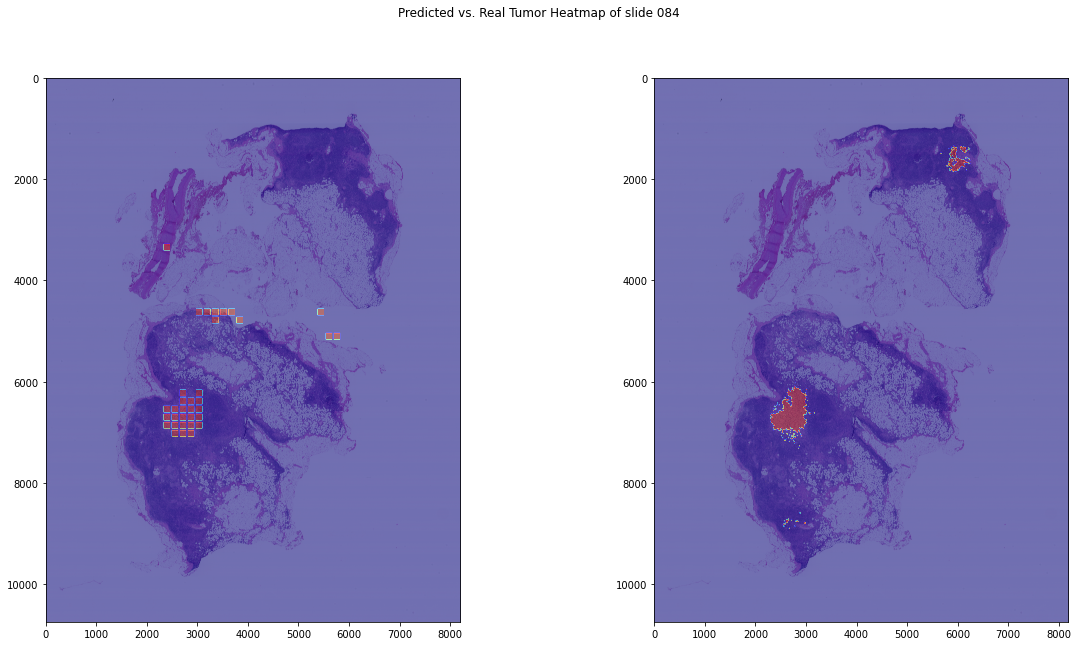

In [ ]:
#@title Generate heatmaps

for slide_num in test_file:
  print("\nLabel heatmap for", slide_num)
  
  level_lst = [3, 5, 7]
  multi_slide_images = []
  multi_mask_images = []
  for level in level_lst:
    slide_image = read_full_image(slide_num, level=level, ifmask=False)
    mask_image = read_full_image(slide_num, level=level, ifmask=True)
    multi_slide_images.append(slide_image)
    multi_mask_images.append(mask_image)

  predict_mask = np.zeros(multi_mask_images[0].shape, dtype=float)
  print("The shape of predict_mask", predict_mask.shape)
  print("The number of tumor of predict_mask", predict_mask.sum())

  predict_mask = label_heatmap_multizooms(
      multi_slide_images, multi_mask_images, predict_mask, 
      threshold=0.5, step=10, pred_level=3, patch_len=299, 
      show_res=True, verbose=0)
  print("The number of tumor of predict_mask after labeling", predict_mask.sum())
  
  f, axarr = plt.subplots(1,2) 
  f.set_figheight(10)
  f.set_figwidth(20)
  f.suptitle(f'Predicted vs. Real Tumor Heatmap of slide {slide_num}')
  axarr[0].imshow(multi_slide_images[0])
  axarr[0].imshow(predict_mask, cmap='jet', alpha=0.5)
  axarr[1].imshow(multi_slide_images[0])
  axarr[1].imshow(multi_mask_images[0], cmap='jet', alpha=0.5)
  plt.show()